# Qubit Two Tone Frequency and Power Sweep

This experiment run a sweep in both Qubit Power and Qubit Frequency. The VNA is used to track the changes at the read-out resonator and needs to be set at the frequency corresponding to the flux value used for the measurement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
import HelpModule  as help
from E5080B_driver import *
from ZNB26_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep

from ERASynthPP_driver import ERASynthPlusPlus
from qcodes import Instrument

In [2]:
#lo = SGS100A_driver('TCPIP0::192.168.0.36::inst0::INSTR')
lo = ERASynthPlusPlus('ERASynthPlusPlus', 'ASRL/dev/ttyACM0::INSTR')
#vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna = ZNB26_driver('TCPIP0::192.168.0.236::inst0::INSTR')
vna.open()
#lo.open()#Removed                              for ERASynh
f_c = 0    # Initial Frequency 

twpa_on = False
if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.39::inst0::INSTR')
    twpa.open()
else:
    twpa = SGS100A_driver('dummy')

Connected to: ERA Instruments ERASynth++ (serial:0081, firmware:v1.0.18) in 0.23s
Could not connect to dummy


In [4]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'twotone_f_pow_psweep'


# Qubit Parameters
params['qubit_name'] = 'QPU-09_Q1_2tone-f-pow'
params['qubit_power'] = -40 #-8
params['twpa_power'] = 0.0
params['twpa_frequency'] = 0.0
params['twpa_on'] = False
params['vna_power'] = -60 #Single Photon Regime
params['center_freq'] = 5.828918e9
params['span_freq'] = 10
params['flux_curr'] = 0
params['temp'] = 9
params['comment'] = "# QPU-09_Q1_2tone-f-pow\n" +\
                    "# Qubit 01 " +\
                    "# " +\
                    "# " +\
                    "# \n" 


# Test Parameters
params['qubitFreqInitial'] = 3000
params['qubitFreqFinal'] = 4000
params['qubitFreqStep'] = 5


params['qubit_power_initial'] = -15
params['qubit_power_final'] = -61
params['qubit_power_step'] = -5

meas = 'S21'

if params['twpa_on']:
    twpa.setup(params['twpa_frequency'], params['twpa_power'])

qubitFreq_array = np.arange(params['qubitFreqInitial'],params['qubitFreqFinal'],params['qubitFreqStep'])
lopower_array = np.arange(params['qubit_power_initial'],params['qubit_power_final'],params['qubit_power_step'])


# Check that the f of the resonator is correct 
f_c=0
if f_c == 0:
    with twpa:
        freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
    f_c, Qf, fwhm, mag_dB_minf, figf, fig_dBf = Q(freqs,mag, True)
    print('Center frequency: %2.2f Hz'%f_c)
    print('FWHM: %2.2f kHz'%(fwhm*1e-3))
    print('Quality Factor: %2.2f'%Qf)

#Initialize the VNA for the 2tone measurement
with twpa:
    freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3, meas = meas)

maxv = np.mean(mag)
delay = 1.5

#Initialize the Local Oscillator
#lo.open()#Removed                              for ERASynh
lo.set_level(min(lopower_array)) # dBm
#lo.close()#Removed                              for ERASynh
tt = (delay+1)*(len(lopower_array)*len(qubitFreq_array))/60.0
print('Estimated time for test = %2.2f min'%tt)

vna.start_rf()

Center frequency: 5828838000.00 Hz
FWHM: 1076.08 kHz
Quality Factor: 5416.72
Estimated time for test = 83.33 min


In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as go 


#Initialize variables for storage
mags = np.ndarray((len(qubitFreq_array),len(lopower_array)))
phases = np.ndarray((len(qubitFreq_array),len(lopower_array)))

mags[:] =maxv
phases[:] = 0

try:
    for idx_power, lo_power in enumerate(lopower_array): 

        with twpa:
            #Update center frequecy of the resonator
            freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
            f_c, Qf, fwhm, mag_dB_minf, figf, fig_dBf = Q(freqs,mag, True)
            
            print('Center frequency: %2.2f Hz'%f_c)
            print('FWHM: %2.2f kHz'%(fwhm*1e-3))
            print('Quality Factor: %2.2f'%Qf)

            freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3, meas = meas)
            phase0 = np.mean(phase)
        
        #with(lo):#Removed                              for ERASynh
        lo.set_level(lo_power)

        sleep(0.1)
        for idx,qfreq in enumerate(qubitFreq_array):
            #with lo:#Removed                           for ERASynh
            lo.set_RF(qfreq*1e6) # *1e6                 for ERASynh
            lo.on()  #Added                             for ERASynh
            with twpa:   
                sleep(0.2)
                clear_output(wait=True)
                vna.reset_average()
                sleep(delay)
                mag, phase =  vna.get_data( meas = meas)
                mags[idx,idx_power] = mag[1]
                phases[idx,idx_power] = phase[1]-phase0
            lo.off() #Added                             for ERASynh

            # Plot
            fig_ = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
            fig_.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=mags, colorbar=dict(x=.45,len=1)))
            fig_.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
            fig_.show()

            #plt.pcolor(lopower_array,qubitFreq_array,mags)
            #plt.show()
    Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    print('Measurement finished. Stopping the sources.')
    vna.stop_rf()


filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
header_str = get_plot_str(params, filename)
np.savez("./data/"+filename,
         header = header_str,
         freqs=qubitFreq_array,
         axis2 = lopower_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

Measurement finished. Stopping the sources.
file saved as twotone_f_pow_psweep_QPU-09_Q1_2tone-f-pow_20241016_1331


In [22]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=mags, colorbar=dict(x=.45,len=1)))
fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
fig.show()

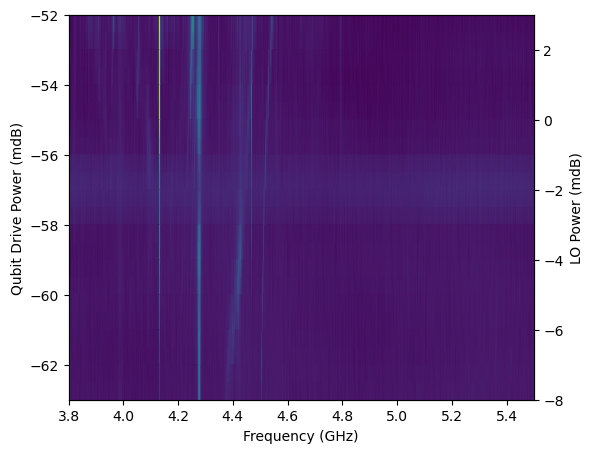

In [42]:
att = 55
# plt.pcolormesh(qubitFreq_array,lopower_array[:]-att,np.transpose(mags[:,:]), 
#                cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
# plt.show()
# att = 55

fig, ax1 = plt.subplots()
fig.set_size_inches(6,5)

ax1.pcolormesh(qubitFreq_array*1e-3,lopower_array[:]-att,(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('Qubit Drive Power (mdB)')
plt.xlabel('Frequency (GHz)')

ax2 = ax1.twinx()
ax2.pcolormesh(qubitFreq_array*1e-3,lopower_array[:],(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('LO Power (mdB)')
plt.xlabel('Frequency (GHz)')
plt.show()

In [21]:
#lo.print_readable_snapshot(update=True)
print(lo.get_idn())
print('\n '+ 'SN : ' + lo.get_diagnostic_status('serial_number'))
lo.get_diagnostic_status()


{'vendor': 'ERA Instruments', 'model': 'ERASynth++', 'serial': '0081', 'firmware': 'v1.0.18'}

 SN : 0081


{'temperature': '30.2',
 'lock_xtal': '1',
 'lock_lmx1': '0',
 'lock_lmx2': '0',
 'current': '0.21',
 'voltage': '5.24',
 'rssi': '',
 'em': 'v1.0.18',
 'ESP8266em': 'v1.0.6',
 'serial_number': '0081',
 'model': '2'}

In [ ]:
lo.close()